# Decision Tree

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn import metrics, model_selection, tree
from sklearn.ensemble import GradientBoostingClassifier
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from statistics import mean

In [2]:
# Se importan los data sets
# Train data
X_train = pd.read_csv('x_train.csv').to_numpy()
y_train = pd.read_csv('y_train.csv')
y_train = y_train['HasDetections']

# Test data
X_test = pd.read_csv('x_test.csv').to_numpy()
y_test = pd.read_csv('y_test.csv')
y_test = y_test['HasDetections']

# Validation data
X_validation = pd.read_csv('x_validation.csv').to_numpy()
y_validation = pd.read_csv('y_validation.csv')
y_validation = y_validation['HasDetections']

## Decision Tree

In [3]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth = 6, random_state = 42)

In [4]:
# Se eliminan los NaN values
np.any(np.isnan(X_train))
X_train = np.nan_to_num(X_train)
np.any(np.isnan(X_train))

np.any(np.isnan(X_test))
X_test = np.nan_to_num(X_test)
np.any(np.isnan(X_test))

np.any(np.isnan(X_validation))
X_validation = np.nan_to_num(X_validation)
np.any(np.isnan(X_validation))

False

In [5]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

#### Validation data

In [6]:
clf.score(X_validation, y_validation)

0.5975701579632622

In [7]:
pred_validation = clf.predict(X_validation)

In [8]:
print("Validation accuracy:\n", metrics.accuracy_score(y_validation, pred_validation))
print('\nMatriz de confusion:\n', metrics.confusion_matrix(y_validation, pred_validation))
print('\nMetricas de evaluacion:\n',metrics.classification_report(y_validation, pred_validation, target_names=['0', '1']))

Validation accuracy:
 0.5975701579632622

Matriz de confusion:
 [[69043 58491]
 [44127 83335]]

Metricas de evaluacion:
               precision    recall  f1-score   support

           0       0.61      0.54      0.57    127534
           1       0.59      0.65      0.62    127462

    accuracy                           0.60    254996
   macro avg       0.60      0.60      0.60    254996
weighted avg       0.60      0.60      0.60    254996



Las detecciones (positivas y negativas) tuvieron resultados semejantes. En precision 55% para la data de validacion, pero para recall y f1-score las detecciones negativa sobtuvieron mayor porcentaje

#### Test data

In [9]:
clf.score(X_test, y_test)

0.5978942163382698

In [10]:
pred_test = clf.predict(X_test)

In [11]:
print("Validation accuracy:\n", metrics.accuracy_score(y_test, pred_test))
print('\nMatriz de confusion:\n', metrics.confusion_matrix(y_test, pred_test))
print('\nMetricas de evaluacion:\n',metrics.classification_report(y_test, pred_test, target_names=['0', '1']))

Validation accuracy:
 0.5978942163382698

Matriz de confusion:
 [[140395 118895]
 [ 89282 169145]]

Metricas de evaluacion:
               precision    recall  f1-score   support

           0       0.61      0.54      0.57    259290
           1       0.59      0.65      0.62    258427

    accuracy                           0.60    517717
   macro avg       0.60      0.60      0.60    517717
weighted avg       0.60      0.60      0.60    517717



Las detecciones (positivas y negativas) tuvieron resultados semejantes. En precision, recall y f1-score ambas obtuvieron 55% para la data de test

In [12]:
# se guarda el modelo 
joblib.dump(clf, 'modelo1.h5')

['modelo1.h5']

#### Evaluacion del modelo

*Cross Validation*

In [13]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
scores

array([0.60026683, 0.59695266, 0.59787385, 0.59857268, 0.59501498,
       0.59939858, 0.59914446, 0.5995214 , 0.59538129, 0.59903433])

In [14]:
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.598 (0.002)


In [15]:
from sklearn.model_selection import RepeatedKFold
kf = KFold(n_splits=10)
for train, test in kf.split(X_train):
    print("%s %s" % (train, test))

[ 94443  94444  94445 ... 944424 944425 944426] [    0     1     2 ... 94440 94441 94442]
[     0      1      2 ... 944424 944425 944426] [ 94443  94444  94445 ... 188883 188884 188885]
[     0      1      2 ... 944424 944425 944426] [188886 188887 188888 ... 283326 283327 283328]
[     0      1      2 ... 944424 944425 944426] [283329 283330 283331 ... 377769 377770 377771]
[     0      1      2 ... 944424 944425 944426] [377772 377773 377774 ... 472212 472213 472214]
[     0      1      2 ... 944424 944425 944426] [472215 472216 472217 ... 566655 566656 566657]
[     0      1      2 ... 944424 944425 944426] [566658 566659 566660 ... 661098 661099 661100]
[     0      1      2 ... 944424 944425 944426] [661101 661102 661103 ... 755540 755541 755542]
[     0      1      2 ... 944424 944425 944426] [755543 755544 755545 ... 849982 849983 849984]
[     0      1      2 ... 849982 849983 849984] [849985 849986 849987 ... 944424 944425 944426]


*Grafica de la curva ROC*

In [16]:
# Extraido de: https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic curves')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

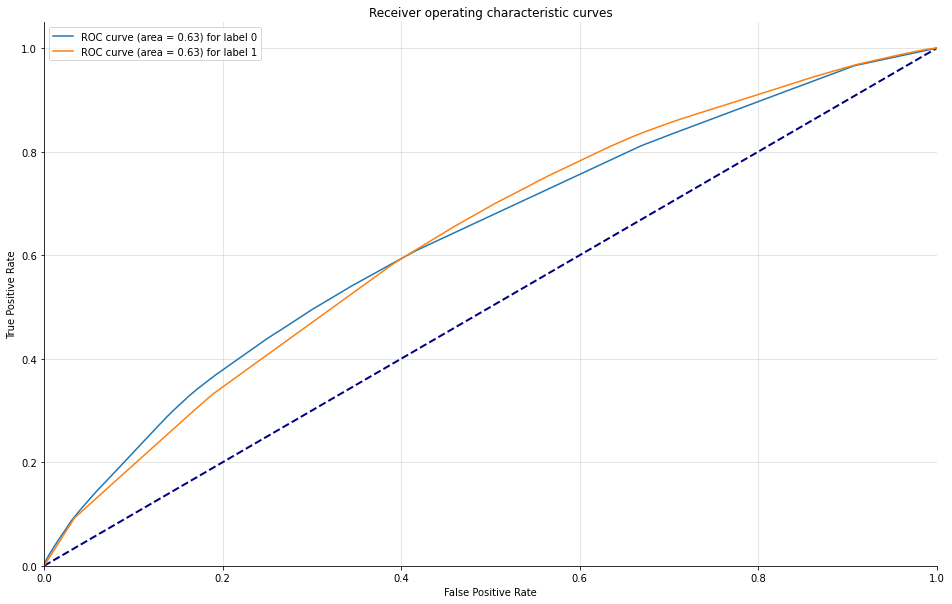

In [17]:
plot_multiclass_roc(clf, X_test, y_test, n_classes=2, figsize=(16, 10))